# NLP consulting sample

#### Author: Timothy Guo

### Key Work Summary

1. No data cleaning is performed
2. Whether the words *'to'*, *'from'* are present in **transaction_description** are used to engineer new features
3. A Linear Support Vector Classifier is the optimal model selected
4. The final model accuracy is 96.3%


## 0. Setup

---

### Versions

Numpy: 1.19.5

Pandas: 1.1.5

Matplotlib: 3.2.2

Tqdm: 4.62.3

Sklearn: 1.0

Xgboost: 0.90

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [ ]:
pd.set_option('display.max_colwidth', None)
set_config(display='diagram')

In [ ]:
FILE_NAME = 'data_sample.csv'

df = pd.read_csv(FILE_NAME)

## 1. Inspect Data
---

In [ ]:
print(f'Number of data samples: {df.shape[0]}')
print(f'Number of data features: {df.shape[1]}')

Number of data samples: 410
Number of data features: 6


In [ ]:
print('Check for missing values.\n')
print(df.isnull().sum())

Check for missing values.

transaction_description     0
transaction_amount          0
transaction_account_type    0
transaction_class           0
description_cleaned         0
transaction_type            0
dtype: int64


In [ ]:
print('Check data types.\n')
print(df.dtypes)

Check data types.

transaction_description      object
transaction_amount          float64
transaction_account_type     object
transaction_class            object
description_cleaned          object
transaction_type             object
dtype: object


In [ ]:
print('Check class categories.\n')
print(df.nunique())

Check class categories.

transaction_description     408
transaction_amount          266
transaction_account_type      6
transaction_class             6
description_cleaned         337
transaction_type              2
dtype: int64


### 1.1 Summary

From the preceeding inspection, we can conclude the following:
- There are no missing values
- The columns are correctly formatted

We have also made an assumption that there are no outliers in the dataset. This is because the dataset we have been given has already been cleaned and any 'outlier' would have been cleaned at an earlier stage. Thus any outlier removal should not be performed here.

We can procede with our analysis without any cleaning needed.


## 2. Data Profile 

---


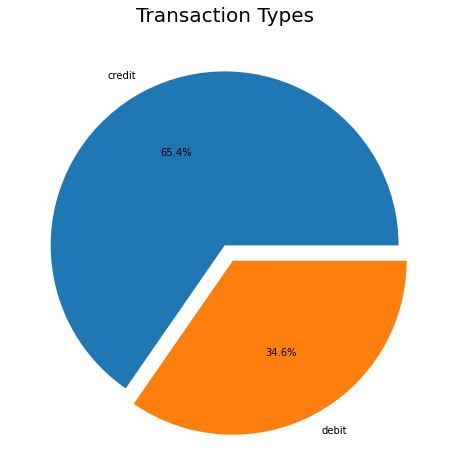

In [ ]:
# Plot Transaction Type class constitution
plt.figure(figsize=(8, 8))
type_count = df.transaction_type.value_counts()
plt.pie(type_count, labels=type_count.index, colors=sns.color_palette(), autopct='%.1f%%', explode=[0,.1])
plt.title("Transaction Types", fontsize=20)
plt.show()

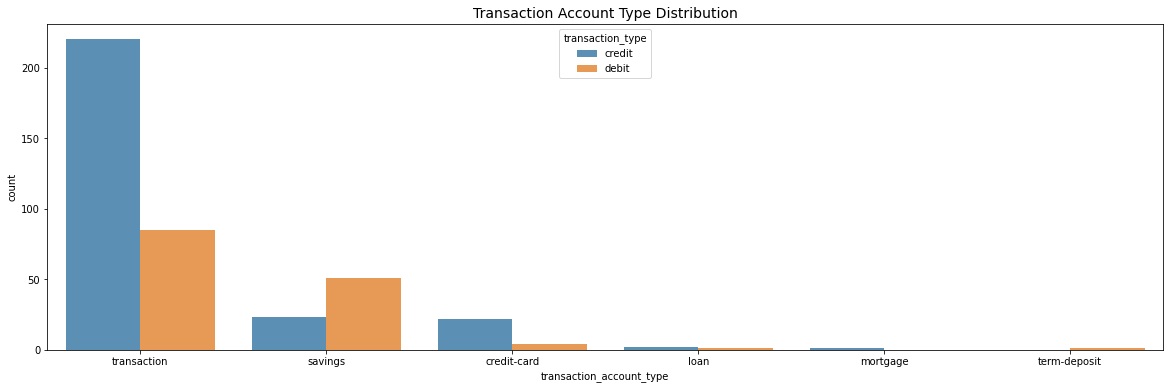

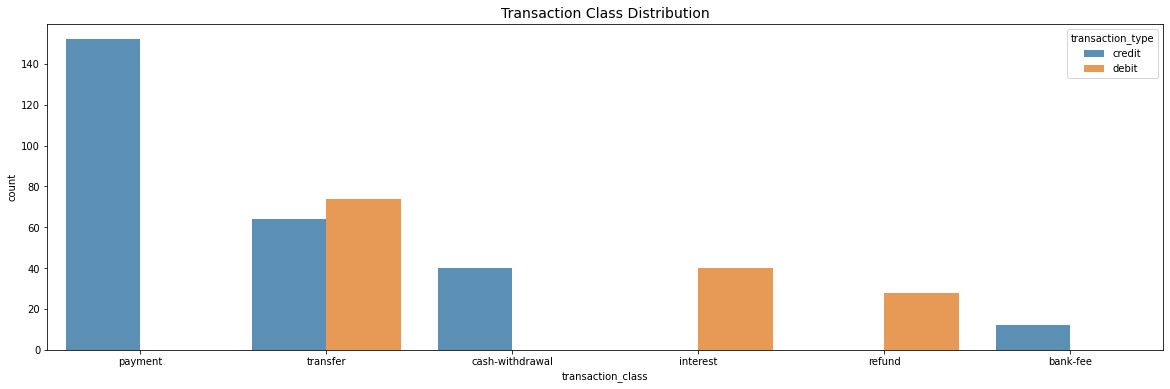

In [ ]:
# Compare Transaction Types for different Transaction Account Type categories
plt.figure(figsize=(20, 6))
order = df.transaction_account_type.value_counts().sort_values(ascending=False).index
sns.countplot(x='transaction_account_type', data=df, hue='transaction_type', linewidth=3, order=order, alpha=0.8)
plt.title("Transaction Account Type Distribution", fontsize=14)
plt.show()

# Compare Transaction Types for different Transaction Class categories
plt.figure(figsize=(20, 6))
order = df.transaction_class.value_counts().sort_values(ascending=False).index
sns.countplot(x='transaction_class', hue='transaction_type', data=df, linewidth=3, order=order, alpha=0.8)
plt.title("Transaction Class Distribution", fontsize=14)
plt.show()

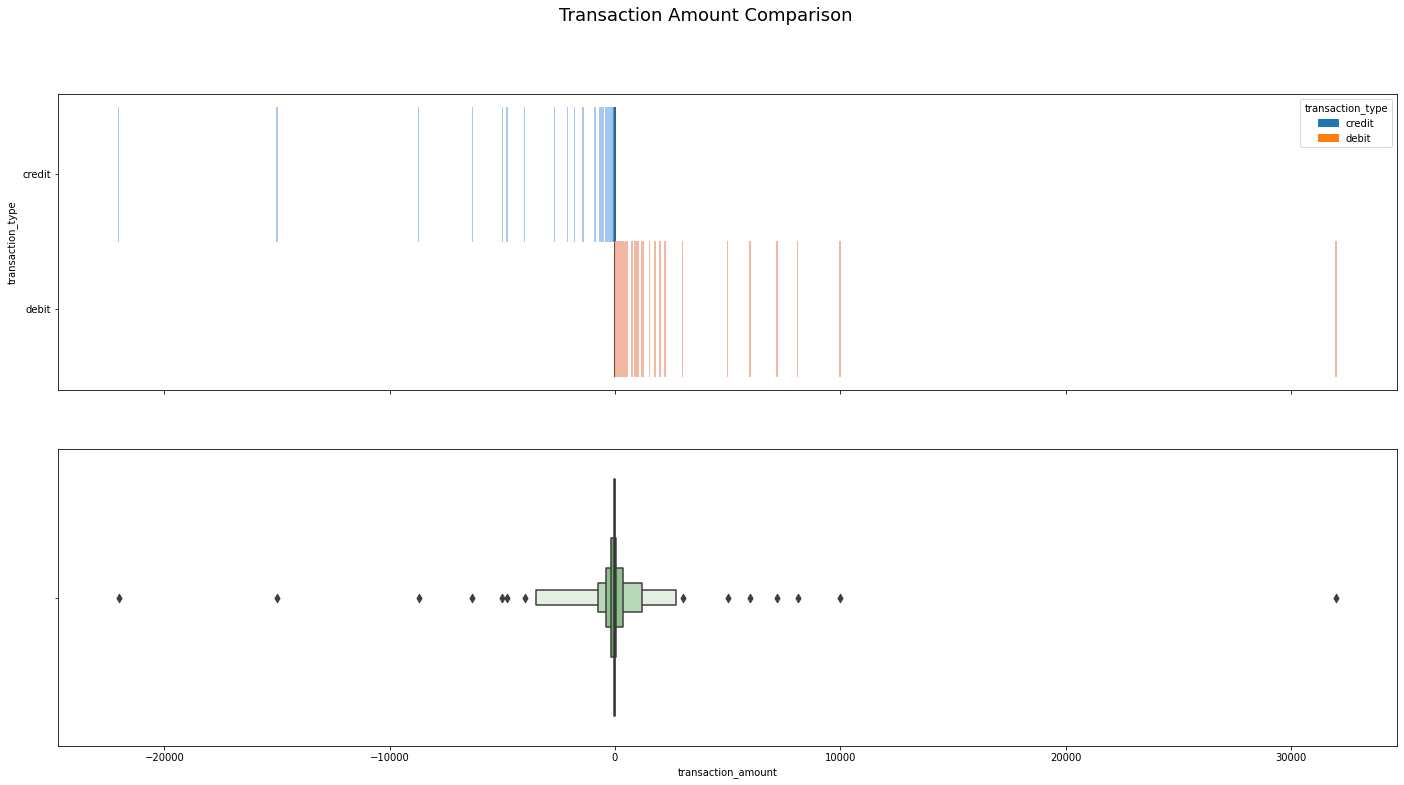

In [ ]:
# Compare Transaction Types for different Transaction Amount values
fig, ax = plt.subplots(2, 1, figsize=(24, 12), sharex=True)
plt.suptitle("Transaction Amount Comparison", fontsize=18)
sns.histplot(data=df, x='transaction_amount', y='transaction_type', hue='transaction_type', ax=ax[0])
sns.boxenplot(data=df, x='transaction_amount', ax=ax[1], color=sns.color_palette()[2])
plt.show()

In [ ]:
def get_missing_words(corpus, guide, n=15):
    """
    List the top n words in a corpus that are not present in a guide
    """
    guide_vec = CountVectorizer().fit(guide)
    guide_words = guide_vec.vocabulary_.keys()
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items() if word not in guide_words]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq[:n]

In [ ]:
# Find the top unique cleaned description word in each transaction type
credit_df = df[df.transaction_type=='credit'].description_cleaned
debit_df = df[df.transaction_type=='debit'].description_cleaned

unique_credit_words = get_missing_words(credit_df, debit_df)
unique_debit_words = get_missing_words(debit_df, credit_df)

unique_credit_df = pd.DataFrame(unique_credit_words, columns=['Word','Count'])
unique_debit_df = pd.DataFrame(unique_debit_words, columns=['Word','Count'])

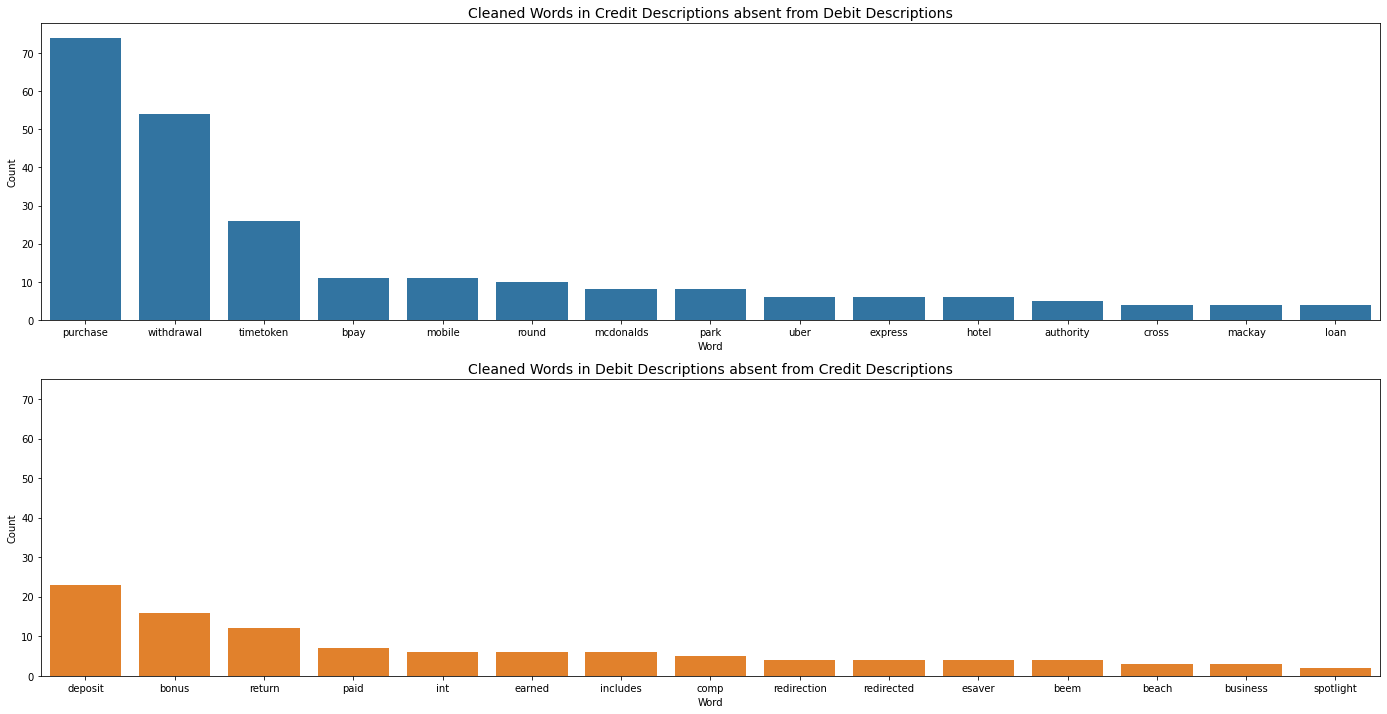

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(24,12))
sns.barplot(data=unique_credit_df, x='Word', y='Count', color=list(sns.color_palette())[0], ax=ax0)
ax0.set_title('Cleaned Words in Credit Descriptions absent from Debit Descriptions', fontsize=14)
sns.barplot(data=unique_debit_df, x='Word', y='Count', color=list(sns.color_palette())[1], ax=ax1)
ax1.set_title('Cleaned Words in Debit Descriptions absent from Credit Descriptions', fontsize=14)
plt.ylim(0, 75)
fig.show()

In [ ]:
# Find the top transaction description words missing from the cleaned description
credit_description_df = df[df.transaction_type=='credit'].transaction_description
debit_description_df = df[df.transaction_type=='debit'].transaction_description

missing_credit_words = get_missing_words(credit_description_df, df.description_cleaned)
missing_debit_words = get_missing_words(debit_description_df, df.description_cleaned)

missing_credit_df = pd.DataFrame(missing_credit_words, columns=['Word','Credit'])
missing_debit_df = pd.DataFrame(missing_debit_words, columns=['Word','Debit'])

missing_df = pd.merge(missing_credit_df, missing_debit_df, how="outer", on='Word')
missing_df['Sum'] = missing_df[['Credit','Debit']].sum(1)
missing_df.sort_values('Sum', ascending=False, inplace=True)

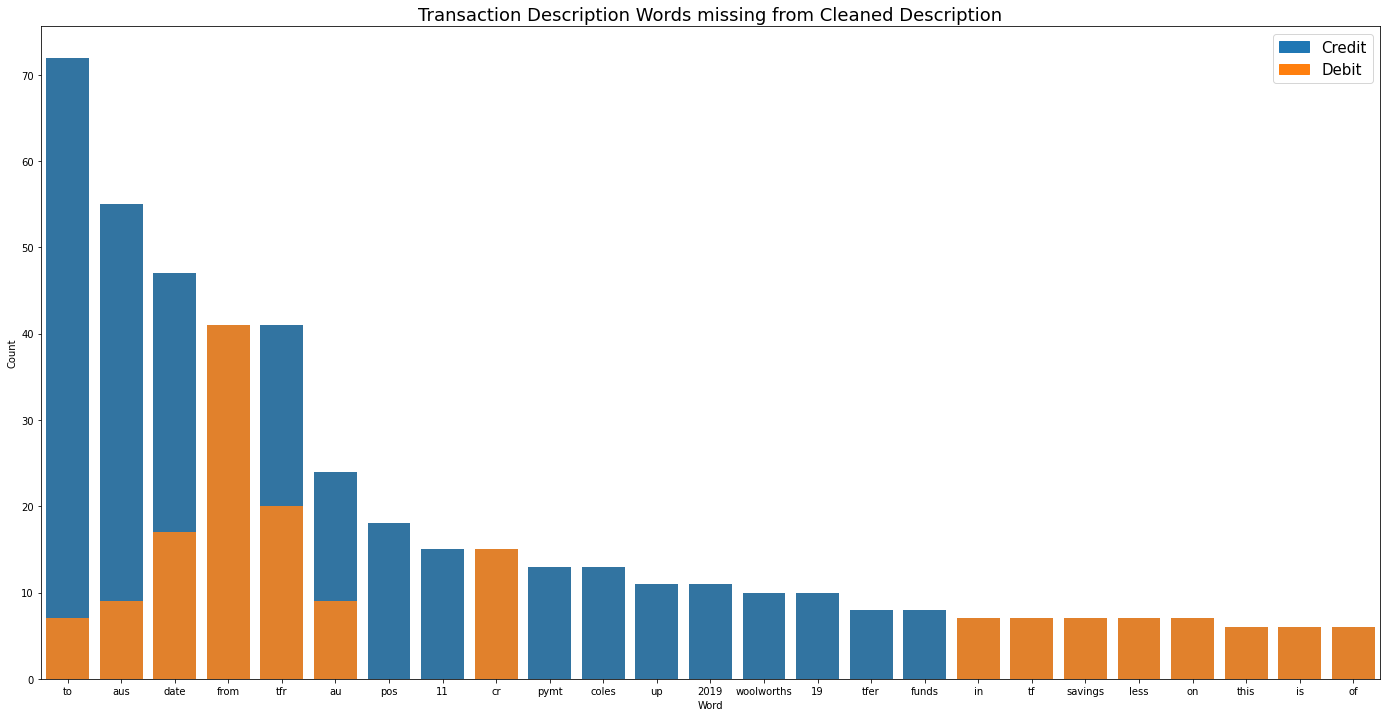

In [ ]:
plt.figure(figsize=(24,12))
sns.barplot(data=missing_df, x='Word', y='Sum', color=sns.color_palette()[0])
sns.barplot(data=missing_df, x='Word', y='Debit', color=sns.color_palette()[1])
bar0 = mpatches.Patch(color=sns.color_palette()[0], label='Credit')
bar1 = mpatches.Patch(color=sns.color_palette()[1], label='Debit')
plt.legend(handles=[bar0, bar1], loc='upper right', fontsize=15)
plt.title('Transaction Description Words missing from Cleaned Description', fontsize=18)
plt.ylabel('Count')
plt.show()

### 2.1 Summary

Here are the key findings:

- *credit* represents most of the **transaction_type** labels
- *term-deposit* and *mortgage* are label unique **transaction_account_type** categories
- *payment*, *cash-withdrawal*, *interest*, *refund* and *bank-fee* are label unique **transaction_class** categories 
- Negative **transaction_amount** are *credit* **transaction_type** and positive **transaction_amount** are *debit* **transaction_type**
- The majority of **transaction_amount** are near 0
- There are key words found only *credit* **transaction_type** or *debit* **transaction_type**
- There are words unique to either *credit* or *debit* **transaction_type** that are missing from **description_cleaned**

Actions following this are:

1. *Drop transaction amount*: in a real-world application, we should use this as it will give us a 100% accuracy in predicting credit/debit type. However for the sake of the exercise, the transaction amount will be omitted to make this more interesting.
2. *Account for dataset imbalance*: use stratified dataset splits to maintain the representation.
3. *Engineer new features*: create new features from the **transaction_description** missing from the **cleaned_description**.
4. *Generalize the learning process*: the dataset is small so we need to minimise overfitting.

## 3. Feature Engineering
---

In [ ]:
class DenseTransformer(TransformerMixin):
    '''
    Convert a sparse matrix type into a dense representation
    '''
    def fit(self, X, y=None, **fit_params):
        return self
        
    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [ ]:
def find_word(word, text):
    '''
    Search if word is in a string sentence
    '''
    if word in text.lower().split():
        return 1
    return 0

In [ ]:
# Define pipeline parameters, engineer new features, split dataset
SEED = 1
TEST_SPLIT = 0.2

drop_columns = ['transaction_description', 'transaction_amount', 'transaction_type']
X = df.drop(drop_columns, axis=1)
y = df.transaction_type

missing_words = ['to', 'from']
missing_word_cols = []
for word in missing_words:
    missing_word_cols.append(word + '_present')
    X[missing_word_cols[-1]] = df.transaction_description.apply(lambda x: find_word(word, x))

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SPLIT,
                                                    stratify=y,
                                                    random_state=SEED,
                                                    )

In [ ]:
# Define and construct preprocessor pipeline stages
text_features = 'description_cleaned'
type_features = ['transaction_account_type', 'transaction_class']
pass_features = missing_word_cols
text_transformer = CountVectorizer(binary=True)
type_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[('text', text_transformer, text_features),
                                               ('type', type_transformer, type_features),
                                               ('pass', 'passthrough', pass_features),
                                               ])

pipeline_steps = [('preprocess', preprocessor),
                  ('dense', DenseTransformer()),
                  ]
                  
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### 3.1 Summary

Here is what was done:

1. New features were engineered from whether the words *'to'* & *'from'* are present in **transaction_description** but absent from **cleaned_description**. These two words are the most distinct in their **transaction_type** attribution.
2. Categorical columns were parsed through an encoder.
3. **Cleaned_description** texts were encoded as a bag of words vector.
4. **Transaction_type** labels were encoded into a binary representation.
5. Pipeline transformations will be applied to the train and test sets independently to prevent data leakage.

## 4. Model Selection
---

### 4.1 Model Selection

In [ ]:
class EvaluateClassifier():
    '''
    Cross-validates pipeline-compatible estimators using an initialized dataset and pipeline
    '''
    def __init__(self, steps, X_train, y_train):
        self.steps = steps
        self.X_train = X_train
        self.y_train = y_train

    def evaluate(self, model):
        base_clf = Pipeline(steps=self.steps + [('classifier', model)])
        scores = cross_val_score(base_clf, self.X_train, self.y_train, cv=10)

        return str(model.__class__()), np.mean(scores)

In [ ]:
# Define and evaulate a suite of classifier
models = [KNeighborsClassifier(1),
          LogisticRegression(random_state=SEED),
          LinearSVC(random_state=SEED),
          DecisionTreeClassifier(random_state=SEED),
          RandomForestClassifier(random_state=SEED),
          MLPClassifier(random_state=SEED,learning_rate='adaptive'),
          XGBClassifier(random_state=SEED,max_depth=8),
          SVC(random_state=SEED),
          ]

eclf = EvaluateClassifier(pipeline_steps, X_train, y_train)
trials = [eclf.evaluate(model) for model in tqdm(models)]
trials = sorted(trials, key=lambda x: x[1], reverse=True)

  0%|          | 0/8 [00:00<?, ?it/s]

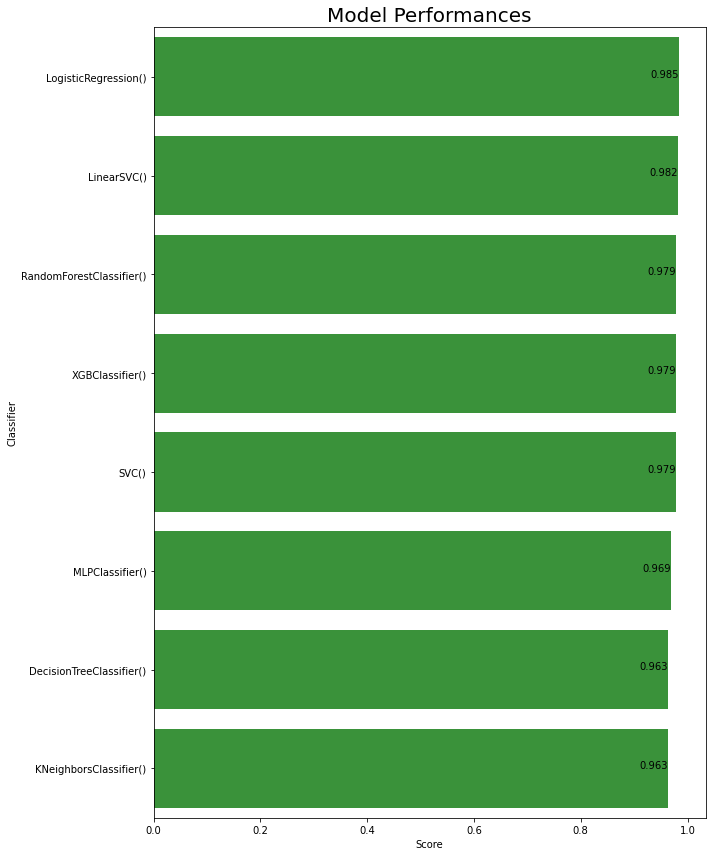

In [ ]:
# Plot performances of each classifier
trials_df = pd.DataFrame(trials, columns=['Classifier', 'Score'])
plt.figure(figsize=(10,12))
fig = sns.barplot(data=trials_df, x='Score', y='Classifier', color=sns.color_palette()[2])
for index, row in trials_df.iterrows():
    fig.text(row.Score, index, round(row.Score, 3), color='black', ha="right")
plt.title('Model Performances', fontsize=20)
plt.tight_layout()
plt.show()

#### 4.1.1 Summary

Here is what was done:

1. *Choose LinearSVC as our model*: LinearSVC and LogisticRegression were the best performing models. LogisticRegression is more prone to overfitting so we will choose LinearSVC. LinearSVC also performed with an acceptable time.

2. *Cross-validation split*: to minimise overfitting due to the small dataset and apply the same validation pipeline to each model.

1. *Minor hyperparameter tuning*: methods have not been thoroughly recorded as it was manually completed to remove limiting parameters.

### 4.2 Model training and reporting


In [ ]:
# Create a tuning experiment
parameters = {'classifier__base_estimator__tol':(1e-1, 1e-2, 1e-3, 1e-4),
              'classifier__base_estimator__C':(0.6, 0.8, 1, 1.2),
              'classifier__base_estimator__dual':(True, False),
              }
clf = CalibratedClassifierCV(LinearSVC(random_state=SEED))
sv_clf = Pipeline(steps=pipeline_steps + [('classifier', clf)])

grid_clf = GridSearchCV(sv_clf, parameters, n_jobs=-1, cv=10)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('text',
                                                                         CountVectorizer(binary=True),
                                                                         'description_cleaned'),
                                                                        ('type',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['transaction_account_type',
                                                                          'transaction_class']),
                                                                        ('pass',
                                                                         'passthrough',
                                                                         ['to_present',
                                                                          'from_present'])])),
                                       ('dense',
                                        <__main__.DenseTransformer object at 0x7f83c5f75750>),
                                       ('classifier',
                                        CalibratedClassifierCV(base_estimator=LinearSVC(random_state=1)))]),
             n_jobs=-1,
             param_grid={'classifier__base_estimator__C': (0.6, 0.8, 1, 1.2),
                         'classifier__base_estimator__dual': (True, False),
                         'classifier__base_estimator__tol': (0.1, 0.01, 0.001,
                                                             0.0001)})

In [ ]:
# Create pipeline with optimal parameters
sv_clf = sv_clf.set_params(**grid_clf.best_params_)
print(grid_clf.best_params_)

{'classifier__base_estimator__C': 0.6, 'classifier__base_estimator__dual': True, 'classifier__base_estimator__tol': 0.1}


In [ ]:
# Measure average training metrics
sv_scores = cross_validate(sv_clf, X_train, y_train, cv=10, return_train_score=True, return_estimator=True)
sv_models = sv_scores.pop('estimator')
pd.DataFrame(sv_scores).mean()

fit_time       0.065644
score_time     0.014056
test_score     0.984659
train_score    0.996950
dtype: float64

In [ ]:
# Test inference
y_prob = np.zeros(y_test.shape[0])
for model in sv_models:
    y_prob += model.predict_proba(X_test)[:,1] / len(sv_models)
y_pred = [int(prob >= 0.5) for prob in y_prob]

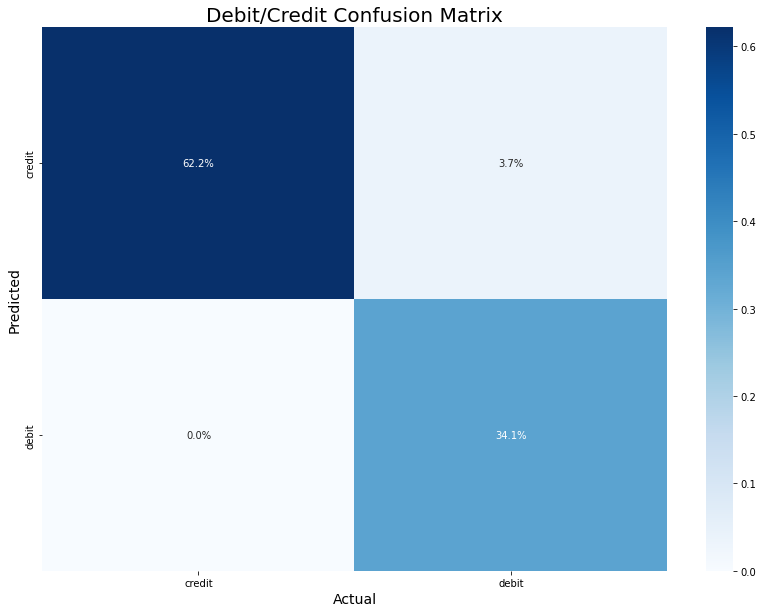

In [ ]:
# Plot classifier prediction confusion matrix
plt.figure(figsize=(14,10))
cm = confusion_matrix(y_test, y_pred)
fig = sns.heatmap(cm/cm.sum(), annot=True, fmt='0.1%', cmap="Blues")
fig.set_xticklabels(le.classes_)
fig.set_yticklabels(le.classes_)
fig.set_xlabel('Actual',fontsize=14)
fig.set_ylabel('Predicted',fontsize=14)
plt.title("Debit/Credit Confusion Matrix",fontsize=20)
plt.show()

### 4.2.1 Summary

Here is what was done:

1. *Hyperparameter tuning*: using GridSearchCV

2. *Cross-validate*: the model using a training data size of 328 samples, completed in 54ms

3. Final test accuracy of the model is 96.3% using a test data size of 82 samples


## 5. Operationalisation
---

There are a few assumptions to be made regarding the data pipeline and the contextual use case:

1. The pipeline framework is cloud-based
2. The users of the model include internal analysts and external clients
3. We have access to a growing source of data
4. There is no pre-existing deployment procedure to follow
5. The product is not a real-time service

The first step in deploying the model is to test its compatibility with the other data pipeline components. As there is no existing guideline to deploy the model, we need to create a minimal impact integration which will be a serverless function such as AWS Lambda. Cloud serverless functions can test the deployment compatibility with our existing methods to access cloud data and an API for users to interact with the model. At this stage, it is important to validate the purpose of the model with only internal users such as our analysts. This small-scale validation will ensure that changes in the model's functionality can be identified and fixed without impacting the client at an early stage.

Once we have validated our model operation, we will shift our attention to the model pipeline. We will implement a one-off training process where a new model is trained using new labelled production data on an iterative basis. All trained models will be stored in a model registry with the newest functional model as the serving model. In the future, we can create specialized models for different data groups and demographics.

The next evolution of the deployment architecture should enable scaling and greater throughput capacity. AWS offers a managed Kubernetes Service to facilitate application management. We will use EKS for both the training and the serving processes of the model. When a prediction is requested by a client, data will be fetched from data sources and processed on nodes spun up to meet the capacity. Depending on the complexity, we can distribute workload by implementing ELT in the fetch process to create the features used for prediction. The model predictions will then be used to update the client data so when the user performs a request for the data, the application will serve the predictions from the datastore. 

The goals of monitoring models in production are:
1. Detect problems early
2. Ensure results are explainable and reportable
3. Enable the capacity to improve

We have already mentioned an aspect of how monitoring will be applied, which was through incremental deployment. We will start from a small group of internal users and progress to the end-users. With each version of the model, a controlled rollout will create an experiment with a small group of users to minimise problems. 

Metrics will be used to monitor models in production. The accuracy of model performance, while they are in production, is essential in determining the number of problems. For example, an accuracy disparity between the training, test, production dataset scores can indicate the need to improve the data or the way the data is preprocessed. 

Operational metrics including inference time, memory usage, latency, system uptime, cost, will all be indicators for whether there has been an improvement in the model's performance, and for detecting problems in the pipeline architecture. Alerts and thresholds are key countermeasures to ensure detectable problems do not go unnoticed. Thankfully, AWS and other cloud services provide such mentioned in-house solutions for every stage of the production model pipeline.

Lastly, logging and metadata cataloguing is a critical procedure through the monitoring and deployment process. This will simply all the troubleshooting that will come in the future as well as provide a historical dimension to the metrics analysis. Some components that will be important to log are pipeline events, data, model metadata, model predictions and operational performances.
